# How to use bikit-models

In [20]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, os.path.abspath('./models'))

import torch

import utils
from vistranet import build_vistra
from daclnet import build_dacl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load an example image

In [23]:
img_path = 'assets\image_0000468_crop_0000001.png'

## Use models from daclnet

=====Model summary=====
The model was instantiated from checkpoints\codebrim-classif-balanced\codebrim-classif-balanced_MobileNetV3-Large_hta.pth with the following arguments:
dataset: codebrim-classif-balanced
base: mobilenet
resolution: 224
run: earnest-durian-22
best_val_loss_cp: 0.23312173125805793
best_val_emr_cp: 0.8607633113861084
best_val_epoch_cp: 44
hidden_layers: [1024]
learning_rate: 1e-05
lr_base: False
scheduler_name: cosine
drop_prob: 0.3
approach: hta
num_class: 6
cat_to_name: {0: 'NoDamage', 1: 'Crack', 2: 'Efflorescence', 3: 'Spalling', 4: 'BarsExposed', 5: 'Rust'}
The base is frozen: True

********** Output **********
NoDamage: 5.47%
Crack: 1.24%
Efflorescence: 0.27%
Spalling: 98.58%
BarsExposed: 96.62%
Rust: 80.03%


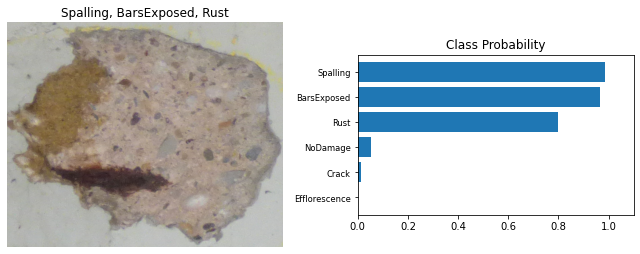

In [24]:
# Preprocess image
img_proc = utils.process_img_daclnet(img_path)

# Instantiate the model:
model, cat_to_name = build_dacl(cp_path='checkpoints\codebrim-classif-balanced\codebrim-classif-balanced_MobileNetV3-Large_hta.pth')

model.eval()
with torch.no_grad(): # Disable tracking of gradients in autograd (saves some time)
    logits = model(img_proc)
    preds = torch.sigmoid(logits).float().squeeze(0)

# Make a dict with the predictions:
preds = preds.flatten()
preds_dict = {v:round(preds[int(k)].item(),4) for k,v in cat_to_name.items()}
print('*'*10, 'Output', '*'*10)
for k,v in preds_dict.items():
    print('%s: %.2f%%' % (k,v*100)) 
# View the classified image and it's predictions:
utils.view_classify(img_path, preds_dict)

## Use model from SOFIA

frozen encoder  encoder
vit_small adapter built. 0 trainable params, 21656833 frozen params.
frozen decoder  decoder
decoder adapter built. 0 trainable params, 9222 frozen params.
quantization
=====Model summary=====
The model was instantiated from checkpoints\codebrim-classif-balanced\codebrim-classif-balanced_ViT_s8.pth and loaded with msg: <All keys matched successfully> with the following arguments:
dateset: codebrim-classif-balanced
img_size: 224
num_class: 6
cat_to_name: {0: 'NoDamage', 1: 'Crack', 2: 'Spalling', 3: 'Efflorescence', 4: 'BarsExposed', 5: 'Rust'}

********** Output **********
NoDamage: 0.04%
Crack: 0.01%
Spalling: 99.94%
Efflorescence: 0.02%
BarsExposed: 97.86%
Rust: 45.18%


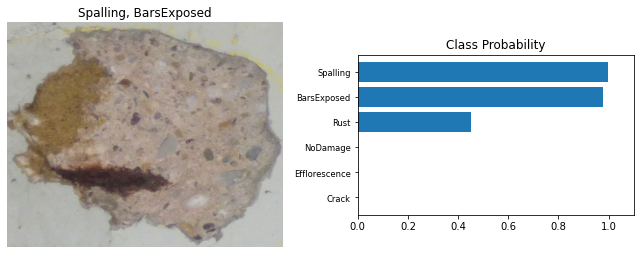

In [19]:
# Preprocess image
img_proc = utils.process_img_vistranet(img_path)

# Instantiate the model:
model, cat_to_name = build_vistra(cp_path='checkpoints\codebrim-classif-balanced\codebrim-classif-balanced_ViT_s8.pth')

model.eval()
with torch.no_grad(): # Disable tracking of gradients in autograd (saves some time)
    logits = model(img_proc)
    preds = torch.sigmoid(logits).float().squeeze(0)

# Make a dict with the predictions:
preds = preds.flatten()
preds_dict = {v:round(preds[int(k)].item(),4) for k,v in cat_to_name.items()}
print('*'*10, 'Output', '*'*10)
for k,v in preds_dict.items():
    print('%s: %.2f%%' % (k,v*100)) 
# View the classified image and it's predictions:
utils.view_classify(img_path, preds_dict)